<a href="https://colab.research.google.com/github/mohmiim/MLIntroduction/blob/master/session-7/FlowerGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import os

!wget --no-check-certificate \
    https://github.com/mohmiim/MLIntroduction/raw/master/session-7/compressedData/flowers1.zip \
    -O /tmp/flowers1.zip
!wget --no-check-certificate \
    https://github.com/mohmiim/MLIntroduction/raw/master/session-7/compressedData/flowers2.zip \
    -O /tmp/flowers2.zip

!wget --no-check-certificate \
    https://github.com/mohmiim/MLIntroduction/raw/master/session-7/compressedData/flowers3.zip \
    -O /tmp/flowers3.zip

!wget --no-check-certificate \
    https://github.com/mohmiim/MLIntroduction/raw/master/session-7/compressedData/flowers4.zip \
    -O /tmp/flowers4.zip


In [0]:
import zipfile
def unzip(file,target):
  zip_ref = zipfile.ZipFile(file, 'r')
  zip_ref.extractall(target)
  zip_ref.close()

unzip("/tmp/flowers1.zip","/tmp/flowers")
unzip("/tmp/flowers2.zip","/tmp/flowers")
unzip("/tmp/flowers3.zip","/tmp/flowers")
unzip("/tmp/flowers4.zip","/tmp/flowers")

In [0]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

def load_samples(location = "data/outline/",width=112, height=112,mode='L') :
  folder = location
  size = (width,height)
  onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
  data_set = np.zeros((len(onlyfiles), size[0], size[1], 3))
  print("Working with {0} images".format(len(onlyfiles)))
  print("Image examples: ")
  i=0
  for _file in onlyfiles:
    if i%100 == 0:
      print('.',end="")
    img = Image.open(folder + _file).convert(mode) 
    img = img.resize(size)
    x = img_to_array(img)  
    data_set[i] = x
    i = i +1
  print(data_set.shape)
  data_set = data_set.astype('float32')
  data_set = (data_set - 127.5) / 127.5
  return data_set    

In [0]:
from numpy.random import randn

LATENT_DIM = 100

def generate_latent_input(latentDim, count):
  X = randn(latentDim * count)
  X = X.reshape((count,latentDim))
  X = X.astype('float32')
  return X

In [0]:
from numpy import zeros
def create_generated_samples(generator, latentDim, count):
    X = generate_latent_input(latentDim, count)
    gen_images = generator.predict(X)
    # labels here will be fake ==> 0
    y = zeros((count,1))
    return gen_images, y

In [0]:
from numpy.random import randint
from numpy import ones

def generate_real_samples(dataset, n_samples):
    index = randint(0, dataset.shape[0], n_samples)
    X = dataset[index]
    # mark them as real
    y = ones((n_samples, 1))
    return X, y


In [0]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.initializers import RandomNormal 

DISC_FILTER_SIZE = 5
DISC_LEAKY_ALPHA = 0.2 

init = RandomNormal(stddev=0.02)
def createDiscConvLayer(model):
    model.add(Conv2D(128, (DISC_FILTER_SIZE,DISC_FILTER_SIZE),
                     strides=(2, 2),
                     padding='same',
                     kernel_initializer=init))
    model.add(LeakyReLU(alpha=DISC_LEAKY_ALPHA))

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

INPUT_SIZE = (80,80,3)
DISC_DROPOUT = 0.4
def create_discriminator(input_shape=INPUT_SIZE):
    print("Creating Discriminator")
    model = Sequential()
    model.add(Conv2D(40, (DISC_FILTER_SIZE,DISC_FILTER_SIZE),
                      padding='same',
                      kernel_initializer=init,
                      input_shape=input_shape))
    model.add(LeakyReLU(alpha=DISC_LEAKY_ALPHA))
    # down sample to 40 X 40
    createDiscConvLayer(model)
    # down sample to 20 X 20
    createDiscConvLayer(model)
    # down sample to 10 X 10
    createDiscConvLayer(model)
    # down sample to 5 X 5
    createDiscConvLayer(model)
    model.add(Flatten())
    model.add(Dropout(DISC_DROPOUT))
    activation = 'sigmoid'
    loss= 'binary_crossentropy'
    model.add(Dense(1, activation=activation))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    print("Created Discriminator")
    model.summary()
    return model

In [11]:
dataset  = load_samples("/tmp/flowers/", width=80, height=80, mode="RGB")

Working with 8189 images
Image examples: 
..................................................................................(8189, 80, 80, 3)


In [12]:
discriminator = create_discriminator()

Creating Discriminator
Created Discriminator
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 40)        3040      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 80, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       128128    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       409728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (C

In [0]:
from tensorflow.keras.layers import Conv2DTranspose

GEN_FILTER_SIZE = 5
GEN_LEAKY_ALPHA = 0.2

def addGenConvTransPoseLayer(model):
  model.add(Conv2DTranspose(128, (GEN_FILTER_SIZE,GEN_FILTER_SIZE),
                            strides=(2,2),
                            padding='same'))
  model.add(LeakyReLU(alpha=GEN_LEAKY_ALPHA))

In [0]:
from tensorflow.keras.layers import Reshape

def create_generator(latent_dim = LATENT_DIM):
  print("Creating Genertor")
  model = Sequential()
  # foundation for 64x64 image
  n_nodes = 128 * 5 * 5
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((5, 5, 128)))
  # up sacle to 10 * 10
  addGenConvTransPoseLayer(model)
  # upsample to 20*20
  addGenConvTransPoseLayer(model)
  # upsample to 40*40
  addGenConvTransPoseLayer(model)
  # upsample to 80*80
  addGenConvTransPoseLayer(model)
  # output layer
  model.add(Conv2D(3, (5,5),
                   activation='tanh',
                   padding='same',
                   kernel_initializer=init))
  print("Created Generator")
  model.summary()
  return model

In [15]:
generator = create_generator()

Creating Genertor
Created Generator
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3200)              323200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       409728    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       409728    
_________________________________________________________________
leaky_re_lu_7 (Lea

In [0]:
def create_gan(generator, discriminator):
    print("Creating GAN")
    # freeze the weights of the discriminator
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    loss= 'binary_crossentropy'
    model.compile(loss=loss, optimizer=opt)
    print("Created GAN")
    model.summary()
    return model

In [0]:
from matplotlib import pyplot

def saveSamples(samples, epoch, n=5):
    samples = (samples + 1) / 2.0
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(samples[i, :, :] )
    pyplot.show()
    pyplot.close()

def generateSampleOutput(epoch, generator, n_samples=10):
    X = generate_latent_input(LATENT_DIM, n_samples*n_samples)
    y = generator.predict(X)
    # save plot
    saveSamples(y, epoch, n_samples)
    # save the generator model tile file
    filename = 'generator_model_%04d.h5' % (epoch + 1)
    generator.save(filename)


In [0]:
import math

def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=500, n_batch=256):
  batches_count = math.ceil(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    print(" ")
    print('>Epoch:%d' % (i+1), end = " ")
    for j in range(batches_count):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, n_batch)
      # generate 'fake' examples
      X_fake, y_fake = create_generated_samples(generator, latent_dim, half_batch)
      # update discriminator model weights
      lossReal, _ = discriminator.train_on_batch(X_real, y_real)
      lossFake, _ = discriminator.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_input(latent_dim, n_batch)
      # mark fake as real
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      loss_generator = gan.train_on_batch(X_gan, y_gan)
      print(".", end="")
      # summarize loss on this batch
    if i%10 == 0 :
      generateSampleOutput(i+1,generator,4)


In [22]:
# create the gan
gan = create_gan(generator, discriminator)


Creating GAN
Created GAN
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 80, 80, 3)         1971715   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1363553   
Total params: 3,335,268
Trainable params: 1,971,715
Non-trainable params: 1,363,553
_________________________________________________________________


 
>Epoch:1 ................................

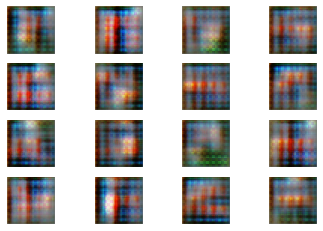

 
>Epoch:2 ................................ 
>Epoch:3 ................................ 
>Epoch:4 ................................ 
>Epoch:5 ................................ 
>Epoch:6 ................................ 
>Epoch:7 ................................ 
>Epoch:8 ................................ 
>Epoch:9 ................................ 
>Epoch:10 ................................ 
>Epoch:11 ................................

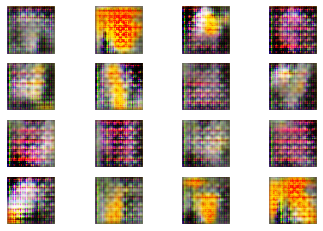

 
>Epoch:12 ................................ 
>Epoch:13 ................................ 
>Epoch:14 ................................ 
>Epoch:15 ................................ 
>Epoch:16 ................................ 
>Epoch:17 ................................ 
>Epoch:18 ................................ 
>Epoch:19 ................................ 
>Epoch:20 ................................ 
>Epoch:21 ................................

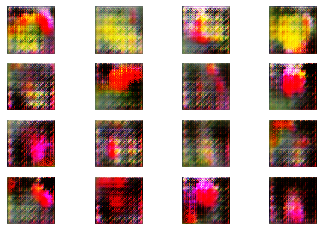

 
>Epoch:22 ................................ 
>Epoch:23 ................................ 
>Epoch:24 ................................ 
>Epoch:25 ................................ 
>Epoch:26 ................................ 
>Epoch:27 ................................ 
>Epoch:28 ................................ 
>Epoch:29 ................................ 
>Epoch:30 ................................ 
>Epoch:31 ................................

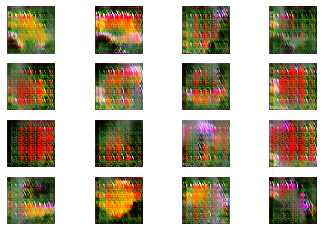

 
>Epoch:32 ................................ 
>Epoch:33 ................................ 
>Epoch:34 ................................ 
>Epoch:35 ................................ 
>Epoch:36 ................................ 
>Epoch:37 ................................ 
>Epoch:38 ................................ 
>Epoch:39 ................................ 
>Epoch:40 ................................ 
>Epoch:41 ................................

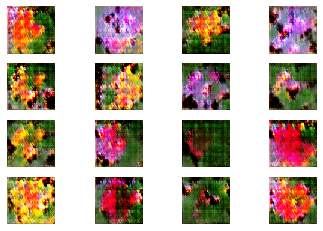

 
>Epoch:42 ................................ 
>Epoch:43 ................................ 
>Epoch:44 ................................ 
>Epoch:45 ................................ 
>Epoch:46 ................................ 
>Epoch:47 ................................ 
>Epoch:48 ................................ 
>Epoch:49 ................................ 
>Epoch:50 ................................ 
>Epoch:51 ................................

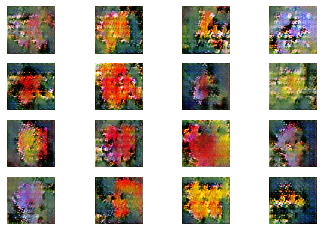

 
>Epoch:52 ................................ 
>Epoch:53 ................................ 
>Epoch:54 ................................ 
>Epoch:55 ................................ 
>Epoch:56 ................................ 
>Epoch:57 ................................ 
>Epoch:58 ................................ 
>Epoch:59 ................................ 
>Epoch:60 ................................ 
>Epoch:61 ................................

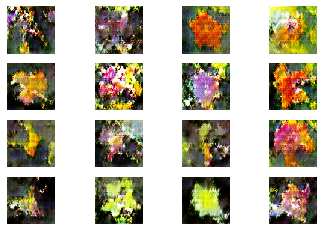

 
>Epoch:62 ................................ 
>Epoch:63 ................................ 
>Epoch:64 ................................ 
>Epoch:65 ................................ 
>Epoch:66 ................................ 
>Epoch:67 ................................ 
>Epoch:68 ................................ 
>Epoch:69 ................................ 
>Epoch:70 ................................ 
>Epoch:71 ................................

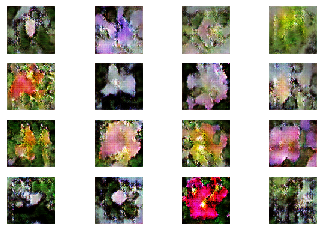

 
>Epoch:72 ................................ 
>Epoch:73 ................................ 
>Epoch:74 ................................ 
>Epoch:75 ................................ 
>Epoch:76 ................................ 
>Epoch:77 ................................ 
>Epoch:78 ................................ 
>Epoch:79 ................................ 
>Epoch:80 ................................ 
>Epoch:81 ................................

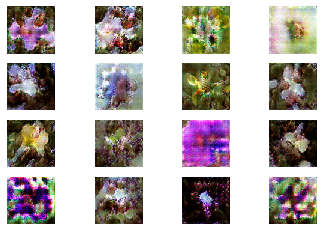

 
>Epoch:82 ................................ 
>Epoch:83 ................................ 
>Epoch:84 ................................ 
>Epoch:85 ................................ 
>Epoch:86 ................................ 
>Epoch:87 ................................ 
>Epoch:88 ................................ 
>Epoch:89 ................................ 
>Epoch:90 ................................ 
>Epoch:91 ................................

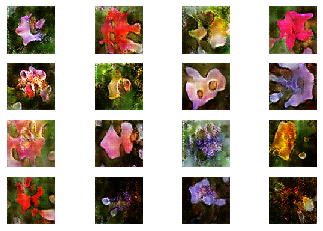

 
>Epoch:92 ................................ 
>Epoch:93 ................................ 
>Epoch:94 ................................ 
>Epoch:95 ................................ 
>Epoch:96 ................................ 
>Epoch:97 ................................ 
>Epoch:98 ................................ 
>Epoch:99 ................................ 
>Epoch:100 ................................ 
>Epoch:101 ................................

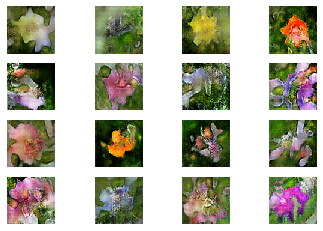

 
>Epoch:102 ................................ 
>Epoch:103 ................................ 
>Epoch:104 ................................ 
>Epoch:105 ................................ 
>Epoch:106 ................................ 
>Epoch:107 ................................ 
>Epoch:108 ................................ 
>Epoch:109 ................................ 
>Epoch:110 ................................ 
>Epoch:111 ................................

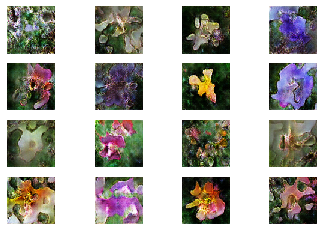

 
>Epoch:112 ................................ 
>Epoch:113 ................................ 
>Epoch:114 ................................ 
>Epoch:115 ................................ 
>Epoch:116 ................................ 
>Epoch:117 ................................ 
>Epoch:118 ................................ 
>Epoch:119 ................................ 
>Epoch:120 ................................ 
>Epoch:121 ................................

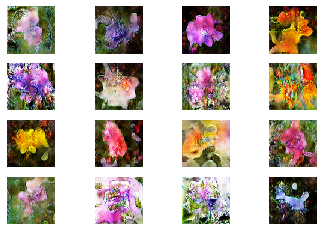

 
>Epoch:122 ................................ 
>Epoch:123 ................................ 
>Epoch:124 ................................ 
>Epoch:125 ................................ 
>Epoch:126 ................................ 
>Epoch:127 ................................ 
>Epoch:128 ................................ 
>Epoch:129 ................................ 
>Epoch:130 ................................ 
>Epoch:131 ................................

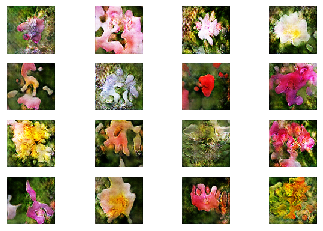

 
>Epoch:132 ................................ 
>Epoch:133 ................................ 
>Epoch:134 ................................ 
>Epoch:135 ................................ 
>Epoch:136 ................................ 
>Epoch:137 ................................ 
>Epoch:138 ................................ 
>Epoch:139 ................................ 
>Epoch:140 ................................ 
>Epoch:141 ................................

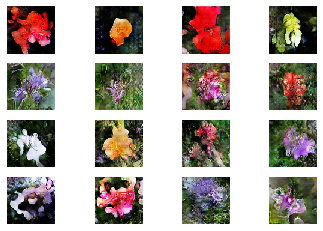

 
>Epoch:142 ................................ 
>Epoch:143 ................................ 
>Epoch:144 ................................ 
>Epoch:145 ................................ 
>Epoch:146 ................................ 
>Epoch:147 ................................ 
>Epoch:148 ................................ 
>Epoch:149 ................................ 
>Epoch:150 ................................ 
>Epoch:151 ................................

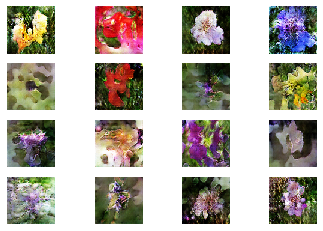

 
>Epoch:152 ................................ 
>Epoch:153 ................................ 
>Epoch:154 ................................ 
>Epoch:155 ................................ 
>Epoch:156 ................................ 
>Epoch:157 ................................ 
>Epoch:158 ................................ 
>Epoch:159 ................................ 
>Epoch:160 ................................ 
>Epoch:161 ................................

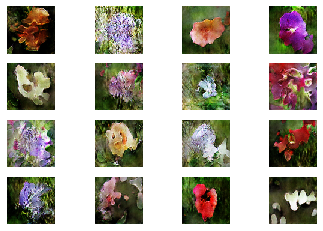

 
>Epoch:162 ................................ 
>Epoch:163 ................................ 
>Epoch:164 ................................ 
>Epoch:165 ................................ 
>Epoch:166 ................................ 
>Epoch:167 ................................ 
>Epoch:168 ................................ 
>Epoch:169 ................................ 
>Epoch:170 ................................ 
>Epoch:171 ................................

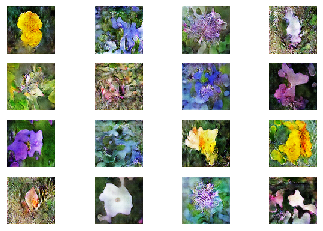

 
>Epoch:172 ................................ 
>Epoch:173 ................................ 
>Epoch:174 ................................ 
>Epoch:175 ................................ 
>Epoch:176 ................................ 
>Epoch:177 ................................ 
>Epoch:178 ................................ 
>Epoch:179 ................................ 
>Epoch:180 ................................ 
>Epoch:181 ................................

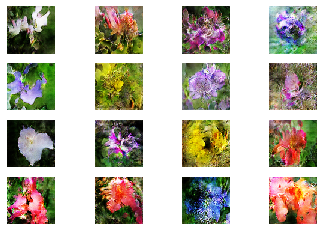

 
>Epoch:182 ................................ 
>Epoch:183 ................................ 
>Epoch:184 ................................ 
>Epoch:185 ................................ 
>Epoch:186 ................................ 
>Epoch:187 ................................ 
>Epoch:188 ................................ 
>Epoch:189 ................................ 
>Epoch:190 ................................ 
>Epoch:191 ................................

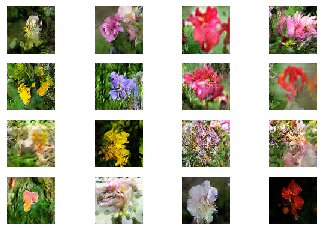

 
>Epoch:192 ................................ 
>Epoch:193 ................................ 
>Epoch:194 ................................ 
>Epoch:195 ................................ 
>Epoch:196 ................................ 
>Epoch:197 ................................ 
>Epoch:198 ................................ 
>Epoch:199 ................................ 
>Epoch:200 ................................ 
>Epoch:201 ................................

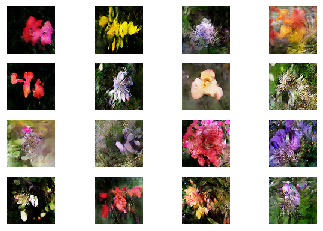

 
>Epoch:202 ................................ 
>Epoch:203 ................................ 
>Epoch:204 ................................ 
>Epoch:205 ................................ 
>Epoch:206 ................................ 
>Epoch:207 ................................ 
>Epoch:208 ................................ 
>Epoch:209 ................................ 
>Epoch:210 ................................ 
>Epoch:211 ................................

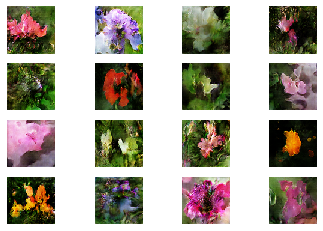

 
>Epoch:212 ................................ 
>Epoch:213 ................................ 
>Epoch:214 ................................ 
>Epoch:215 ................................ 
>Epoch:216 ................................ 
>Epoch:217 ................................ 
>Epoch:218 ................................ 
>Epoch:219 ................................ 
>Epoch:220 ................................ 
>Epoch:221 ................................

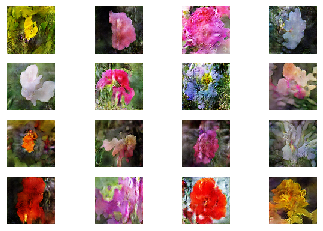

 
>Epoch:222 ................................ 
>Epoch:223 ................................ 
>Epoch:224 ................................ 
>Epoch:225 ................................ 
>Epoch:226 ................................ 
>Epoch:227 ................................ 
>Epoch:228 ................................ 
>Epoch:229 ................................ 
>Epoch:230 ................................ 
>Epoch:231 ................................

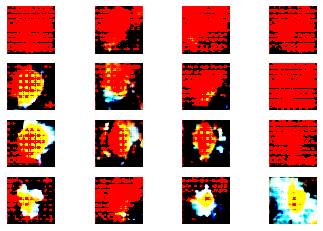

 
>Epoch:232 ................................ 
>Epoch:233 ................................ 
>Epoch:234 ................................ 
>Epoch:235 ................................ 
>Epoch:236 ................................ 
>Epoch:237 ................................ 
>Epoch:238 ................................ 
>Epoch:239 ................................ 
>Epoch:240 ................................ 
>Epoch:241 ................................

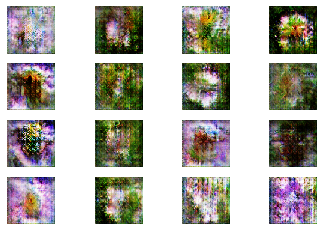

 
>Epoch:242 ................................ 
>Epoch:243 ................................ 
>Epoch:244 ................................ 
>Epoch:245 ................................ 
>Epoch:246 ................................ 
>Epoch:247 ................................ 
>Epoch:248 ................................ 
>Epoch:249 ................................ 
>Epoch:250 ................................ 
>Epoch:251 ................................

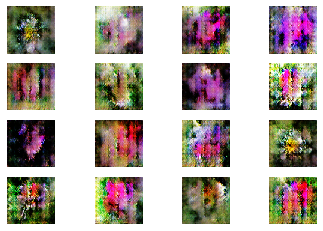

 
>Epoch:252 ................................ 
>Epoch:253 ................................ 
>Epoch:254 ................................ 
>Epoch:255 ................................ 
>Epoch:256 ................................ 
>Epoch:257 ................................ 
>Epoch:258 ................................ 
>Epoch:259 ................................ 
>Epoch:260 ................................ 
>Epoch:261 ................................

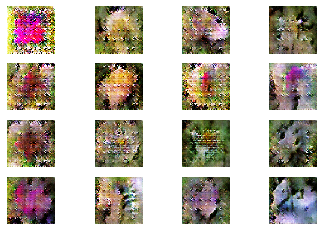

 
>Epoch:262 ................................ 
>Epoch:263 ................................ 
>Epoch:264 ................................ 
>Epoch:265 ................................ 
>Epoch:266 .....

KeyboardInterrupt: ignored

In [26]:
# train model
train(generator, discriminator, gan, dataset, LATENT_DIM)